In [1]:
import argparse
from collections import namedtuple
from dataclasses import dataclass
import json
import logging
import os
import random
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

import transformers
import wandb
from tqdm.auto import tqdm, trange


logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s: %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

In [2]:
def get_data(file_path, sample, num_choices):
    data_file = open(file_path, "r")
    logger.info("Reading QA instances from jsonl dataset at: %s", file_path)
    item_jsons = []
    item_ids = []
    questions = []
    choice_lists = []
    answer_ids = []
    for line in data_file:
        item_jsons.append(json.loads(line.strip()))

    if sample != -1:
        item_jsons = random.sample(item_jsons, sample)
        logger.info("Sampling %d examples", sample)

    for item_json in tqdm(item_jsons,total=len(item_jsons)):
        item_id = item_json["id"]

        question_text = item_json["question"]["stem"]

        choice_label_to_id = {}
        choice_text_list = []
        choice_context_list = []
        choice_label_list = []
        choice_annotations_list = []

        any_correct = False
        choice_id_correction = 0

        for choice_id, choice_item in enumerate(item_json["question"]["choices"]):
            choice_label = choice_item["label"]
            choice_label_to_id[choice_label] = choice_id - choice_id_correction
            choice_text = choice_item["text"]

            choice_text_list.append(choice_text)
            choice_label_list.append(choice_label)

            if item_json.get('answerKey') == choice_label:
                if any_correct:
                    raise ValueError("More than one correct answer found for {item_json}!")
                any_correct = True


        if not any_correct and 'answerKey' in item_json:
            raise ValueError("No correct answer found for {item_json}!")


        answer_id = choice_label_to_id.get(item_json.get("answerKey"))
        # Pad choices with empty strings if not right number
        if len(choice_text_list) != num_choices:
            choice_text_list = (choice_text_list + num_choices * [''])[:num_choices]
            choice_context_list = (choice_context_list + num_choices * [None])[:num_choices]
            if answer_id is not None and answer_id >= num_choices:
                logging.warning(f"Skipping question with more than {num_choices} answers: {item_json}")
                continue

        item_ids.append(item_id)
        questions.append(question_text)
        choice_lists.append(choice_text_list)
        answer_ids.append(answer_id)

    data_file.close()
    return questions, choice_lists, answer_ids

In [3]:
class BERTDataset(Dataset):
    
    def __init__(self, questions, choices, answer_ids, tokenizer, replacement):
        questions = [question.replace("[MASK]", replacement) for question in questions]
        out = tokenizer(questions)
        self.input_ids = out["input_ids"]
        self.token_type_ids = out["token_type_ids"]
        self.attention_mask = out["attention_mask"]
        self.questions = questions
        self.choices = choices
        self.answer_ids = answer_ids
        
    def __len__(self):
        return len(self.questions)

    def __getitem__(self, i):
        return {
            "input_ids": self.input_ids[i], 
            "attention_mask": self.attention_mask[i], 
            "token_type_ids": self.token_type_ids[i],
            "choice_list": self.choices[i], 
            "answer_id": self.answer_ids[i],
        }
    

class RoBERTaDataset(Dataset):
    
    def __init__(self, questions, choices, answer_ids, tokenizer, replacement):
        # if any(prefix in args.model_name_or_path.lower() for prefix in ("roberta", "bart")):
        #     questions = [question.replace('[MASK]','<mask>') for question in questions]
        questions = [question.replace("[MASK]", replacement) for question in questions]
        out = tokenizer(questions)
        self.input_ids = out["input_ids"]
        self.attention_mask = out["attention_mask"]
        self.questions = questions
        self.choices = choices
        self.answer_ids = answer_ids
        
    def __len__(self):
        return len(self.questions)

    def __getitem__(self, i):
        return {
            "input_ids": self.input_ids[i], 
            "attention_mask": self.attention_mask[i], 
            "choice_list": self.choices[i], 
            "answer_id": self.answer_ids[i],
        }
    
CombinedDataset = namedtuple("CombinedDataset", "young_dataset, old_dataset")

In [4]:
def get_sentence_prob(model_name, input_ids, logits):
    #print("--")
    #print(logits)
#     if torch.min(logits) < 0:
#         logits = logits - torch.min(logits) + 1e-10
    logits = torch.nn.functional.softmax(logits, dim=2)
    #print(logits)
    probs = torch.gather(logits, 2, input_ids.unsqueeze(-1)).squeeze(-1)
    if "gpt" in model_name:  # Scaling
        probs = probs * 1e4
    #print(probs)
#     probs2 = torch.zeros_like(input_ids, dtype=float)
#     for batch_ind, logit in enumerate(logits):
#         batch_input_ids = input_ids[batch_ind]
#         for seq_ind, wid in enumerate(batch_input_ids):
#             probs2[batch_ind, seq_ind] = logits[batch_ind, seq_ind, wid]
    
#     assert torch.all(probs == probs2)
    probs = torch.prod(probs, dim=1)
    #probs = torch.prod(probs[:, 1:], dim=1)
    #probs = probs[:, 0]  # CLSes
    #probs = probs[:, 8]  # MASK
    #print(probs)
    #assert False
    return probs

In [5]:
def evaluate(args, model, tokenizer, eval_dataset):
    dataset0, dataset1 = eval_dataset
    eval_dataloader0 = DataLoader(dataset0, batch_size=args.per_device_eval_batch_size, shuffle=False)
    eval_dataloader1 = DataLoader(dataset1, batch_size=args.per_device_eval_batch_size, shuffle=False)

    logger.info(f"***** Running evaluation  *****")
    logger.info(f"  Num examples = {len(dataset0)}")
    logger.info(f"  Batch size = {args.eval_batch_size}")
    eval_dataloader0 = tqdm(eval_dataloader0, desc="Evaluating")
    eval_dataloader1 = tqdm(eval_dataloader1, desc="Evaluating")
    
    all_answers = []
    all_preds = []
    first_age = []
    second_age = []
    young_probs = []
    old_probs = []
    for batch in eval_dataloader0:
        model.eval()
        for i in range(len(batch["answer_id"])):
            if batch["choice_list"][0][i] == "older":
                batch["answer_id"][i] = -batch["answer_id"][i] + 1  # Flip 1 -> 0, 0 -> 1
        
        all_answers.extend(batch["answer_id"].tolist())
        
        del batch["choice_list"] 
        for key in batch:
            if key != "answer_id":
                batch[key] = torch.stack(batch[key], dim=-1)

            batch[key] = batch[key].cuda()
            
        offset = 1 if "gpt" in args.model_name_or_path.lower() else 0
        age1 = tokenizer.decode(batch["input_ids"][:, 2 - offset]).split(" ")
        age2 = tokenizer.decode(batch["input_ids"][:, 11 - offset]).split(" ")
        if any(prefix in args.model_name_or_path.lower() for prefix in ("roberta", "bart", "gpt")):
            age1 = age1[1:]
            age2 = age2[1:]
        
        first_age.extend(age1)
        second_age.extend(age2)
        answer_ids = batch.pop("answer_id")
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            young_probs.extend(get_sentence_prob(args.model_name_or_path, batch["input_ids"], logits).tolist())
            
    for batch in eval_dataloader1:
        model.eval()
#         for i in range(len(batch["answer_id"])):
#             if batch["choice_list"][0][i] == "older":
#                 batch["answer_id"][i] = -batch["answer_id"][i] + 1  # Flip 1 -> 0, 0 -> 1
        
#         all_answers.extend(batch["answer_id"].tolist())
        
        del batch["choice_list"] 
        for key in batch:
            if key != "answer_id":
                batch[key] = torch.stack(batch[key], dim=-1)

            batch[key] = batch[key].cuda()
            
#         age1 = tokenizer.decode(batch["input_ids"][:, 2]).split(" ")
#         age2 = tokenizer.decode(batch["input_ids"][:, 11]).split(" ")
#         if any(prefix in args.model_name_or_path.lower() for prefix in ("roberta", "bart")):
#             age1 = age1[1:]
#             age2 = age2[1:]
        
#         first_age.extend(age1)
#         second_age.extend(age2)
        answer_ids = batch.pop("answer_id")
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            old_probs.extend(get_sentence_prob(args.model_name_or_path, batch["input_ids"], logits).tolist())
            
        
        # preds = torch.gt(logits[:, MASK_INDEX, OLD_ID], logits[:, MASK_INDEX, YOUNG_ID])
        # preds = torch.gt(old_prob, young_prob)
        #print("---")
        #print(preds)
        #print(young_prob)
        #print(old_prob)
        # all_preds.extend(preds.tolist())
    for i in range(len(young_probs)):
        all_preds.append(young_probs[i] < old_probs[i])

    first_age = [int(age) for age in first_age]
    second_age = [int(age) for age in second_age]
    return all_answers, all_preds, first_age, second_age

In [6]:
@dataclass
class CustomArguments(transformers.TrainingArguments):
    sample_train: int = 0
    sample_eval: int = 0
    num_choices: int = 0
    model_name_or_path: str = "asdf"  # this is no longer a TrainingArgument attribute
        
    # python dataclasses cannot have positional attributes in subclass,
    # so give all attributes defaults and then make sure they are changed
    def __post_init__(self):
        if not (self.sample_train * self.sample_eval * self.num_choices) or \
               self.model_name_or_path == "asdf":  # make sure none are still default value
            raise TypeError("__init__ missing required argument(s)")

            
# "bert-base-uncased", 
# "bert-large-uncased-whole-word-masking", 
# "roberta-large",
# "distilbert-base-uncased", 
# "facebook/bart-large",
# "albert-large-v1",
# "google/electra-large-discriminator",
# "gpt2",
# "t5-large",
def get_args():
    """ Set hyperparameters """
    args = CustomArguments(
        output_dir="checkpoint",
        model_name_or_path="facebook/bart-large",
        overwrite_output_dir=True,
        do_train=False,  # Zero shot
        do_eval=True,
        per_device_eval_batch_size=8,
        learning_rate=1e-5,  # Should not matter because not training
        weight_decay=0.1,
        save_total_limit=2,
        seed=123,
        sample_train=200,
        sample_eval=-1,
        num_choices=2,
    )
    
    return args

In [34]:
args = get_args()
transformers.set_seed(args.seed)
model = transformers.AutoModelWithLMHead.from_pretrained(args.model_name_or_path).cuda()
tokenizer = transformers.AutoTokenizer.from_pretrained(args.model_name_or_path)
train_questions, train_choices, train_answer_ids = get_data("data/number_comparison_age_compare_masked_train.jsonl", args.sample_train, args.num_choices)
eval_questions, eval_choices, eval_answer_ids = get_data("data/number_comparison_age_compare_masked_dev.jsonl", args.sample_eval, args.num_choices)

eval_questions = train_questions + eval_questions
eval_choices = train_choices + eval_choices
eval_answer_ids = train_answer_ids + eval_answer_ids

AgeDataset = RoBERTaDataset if any(prefix in args.model_name_or_path.lower() for prefix in ("roberta", "bart", "distil", "gpt2", "t5")) else BERTDataset
train_dataset = CombinedDataset(AgeDataset(train_questions, train_choices, train_answer_ids, tokenizer, "younger"), AgeDataset(train_questions, train_choices, train_answer_ids, tokenizer, "older"))
eval_dataset = CombinedDataset(AgeDataset(eval_questions, eval_choices, eval_answer_ids, tokenizer, "younger"), AgeDataset(eval_questions, eval_choices, eval_answer_ids, tokenizer, "older"))

05/05/2021 09:48:09: Reading QA instances from jsonl dataset at: data/number_comparison_age_compare_masked_train.jsonl
05/05/2021 09:48:09: Sampling 200 examples


  0%|          | 0/200 [00:00<?, ?it/s]

05/05/2021 09:48:09: Reading QA instances from jsonl dataset at: data/number_comparison_age_compare_masked_dev.jsonl


  0%|          | 0/500 [00:00<?, ?it/s]

In [33]:
torch.cuda.empty_cache()

In [35]:
all_answers, all_preds, first_age, second_age = evaluate(args, model, tokenizer, eval_dataset)
# correct = [1 if all_answers[i] == all_preds[i] else 0 for i in range(len(all_answers))]
# print(np.array(correct))

05/05/2021 09:48:09: ***** Running evaluation  *****
05/05/2021 09:48:09:   Num examples = 700
05/05/2021 09:48:09:   Batch size = 8


Evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

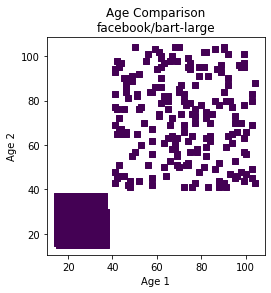

In [36]:
plt.scatter(first_age, second_age, c=all_preds, marker="s")
plt.title(f"Age Comparison\n{args.model_name_or_path}")
plt.axis("square")
plt.xlabel("Age 1")
plt.ylabel("Age 2")
plt.savefig(f"imgs/{args.model_name_or_path.rsplit('/', 1)[-1]}-ages-double-expanded.jpg", bbox_inches="tight")
plt.show()

In [15]:
tokenizer.encode("<s>", add_special_tokens=False)

[0]

In [22]:
asdf = torch.tensor([[[1, 2], [3, 4], [5, 6]], [[11, 12], [13, 14], [15, 16]], [[21, 22], [23, 24], [25, 26]], [[31, 32], [33, 34], [35, 36]]])
asdf

tensor([[[ 1,  2],
         [ 3,  4],
         [ 5,  6]],

        [[11, 12],
         [13, 14],
         [15, 16]],

        [[21, 22],
         [23, 24],
         [25, 26]],

        [[31, 32],
         [33, 34],
         [35, 36]]])

In [26]:
inds = torch.tensor([[[0], [1], [0]], [[0], [0], [0]], [[0], [0], [0]], [[0], [0], [0]]])
torch.gather(asdf, 2, inds)

tensor([[[ 1],
         [ 4],
         [ 5]],

        [[11],
         [13],
         [15]],

        [[21],
         [23],
         [25]],

        [[31],
         [33],
         [35]]])